In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("C:\\Users\\Here\\Desktop\\Disertatie-Final\\4. Cod\\Data\\Phishing_Email.csv"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1| Download the dataset

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d subhajournal/phishingemails

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


Dataset URL: https://www.kaggle.com/datasets/subhajournal/phishingemails
License(s): GNU Lesser General Public License 3.0




  0%|          | 0.00/18.0M [00:00<?, ?B/s]
  6%|▌         | 1.00M/18.0M [00:01<00:32, 558kB/s]
 11%|█         | 2.00M/18.0M [00:06<00:54, 306kB/s]
 17%|█▋        | 3.00M/18.0M [00:08<00:39, 395kB/s]
 22%|██▏       | 4.00M/18.0M [00:11<00:40, 362kB/s]
 28%|██▊       | 5.00M/18.0M [00:12<00:30, 454kB/s]
 33%|███▎      | 6.00M/18.0M [00:14<00:26, 472kB/s]
 39%|███▉      | 7.00M/18.0M [00:15<00:18, 609kB/s]
 44%|████▍     | 8.00M/18.0M [00:16<00:14, 737kB/s]
 50%|████▉     | 9.00M/18.0M [00:18<00:15, 595kB/s]
 55%|█████▌    | 10.0M/18.0M [00:19<00:12, 682kB/s]
 61%|██████    | 11.0M/18.0M [00:21<00:10, 704kB/s]
 67%|██████▋   | 12.0M/18.0M [00:21<00:07, 827kB/s]
 72%|███████▏  | 13.0M/18.0M [00:23<00:06, 775kB/s]
 78%|███████▊  | 14.0M/18.0M [00:25<00:06, 668kB/s]
 83%|████████▎ | 15.0M/18.0M [00:26<00:04, 718kB/s]
 89%|████████▊ | 16.0M/18.0M [00:30<00:04, 454kB/s]
 94%|█████████▍| 17.0M/18.0M [00:33<00:02, 467kB/s]
100%|█████████▉| 18.0M/18.0M [00:34<00:00, 527kB/s]
100%|██████████| 18

In [3]:
!unzip /content/phishingemails.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# 2| Import Necessary libs

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,SimpleRNN
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Dropout
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

# 3| Loading our data

In [6]:
df = pd.read_csv("C:\\Users\\Here\\Desktop\\Disertatie-Final\\4. Cod\\Data\\Phishing_Email.csv")

df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


# 4| Text Preprocessing

In [7]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

** There are 16 rows available that have null values .Let's remove these rows



## 4.1| Drop duplicates and null values

In [8]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [9]:
print("Dimension of the row data:",df.shape)

Dimension of the row data: (17538, 2)


In [10]:
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [11]:
# Create the bar chart
fig = px.bar(df['Email Type'].value_counts(), x=df['Email Type'].value_counts().index, y=df['Email Type'].value_counts().values,
             color=['blue', 'red'], labels={'x': 'Category', 'y': 'Count'},
             title="Categorical Distribution")

# Show the plot
fig.show()

Insigths :

The count of the safe emails is more than that of phishing email so if we see any emails that look like phishing delete

In [12]:
# Create the pie chart
fig_pie = px.pie(df['Email Type'].value_counts(), names=df['Email Type'].value_counts().index,
                 values=df['Email Type'].value_counts().values, title="Categorical Distribution")

# Show the pie chart
fig_pie.show()

## 4.3| Integer Encoding

In [13]:
le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])

In [14]:
df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",1
1,the other side of * galicismos * * galicismo *...,1
2,re : equistar deal tickets are you still avail...,1
3,\nHello I am your hot lil horny toy.\n I am...,0
4,software at incredibly low prices ( 86 % lower...,0
...,...,...
18644,\nRick Moen a Ã©crit:> > I'm confused. I thou...,1
18645,date a lonely housewife always wanted to date ...,0
18646,request submitted : access request for anita ....,1
18647,"re : important - prc mtg hi dorn & john , as y...",1


## 4.4 Remove hyperlinks, punctuations, extra space

In [15]:
import re

def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the preprocess_text function to the specified column in the DataFrame
df["Email Text"] =df["Email Text"].apply(preprocess_text)

In [16]:
df.head()

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0


# WordCloud

## wordcloud of avaiable stopwords

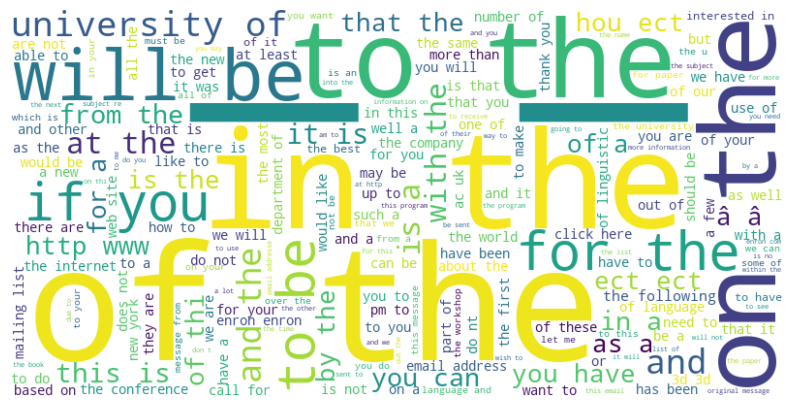

In [17]:
from wordcloud import WordCloud

#combine all rows into a single string
all_mails = " ".join(df['Email Text'])

#create a wordcloud object
word_cloud = WordCloud(stopwords="english",width=800,height=400,background_color='white').generate(all_mails)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## wordcloude of unique words

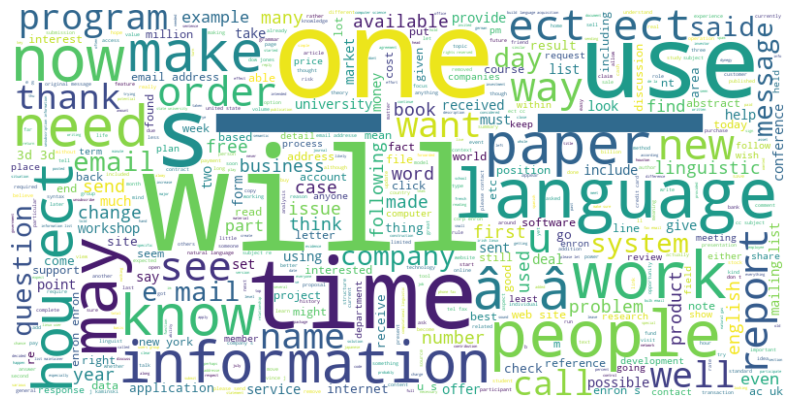

In [18]:
#combine all rows into a single string
all_mails = " ".join(df['Email Text'])

#create a wordcloud object
word_cloud = WordCloud(width=800,height=400,background_color='white',max_words=10000).generate(all_mails)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## 4.5 Converting text into vector

### 4.5.1 Tfidf vectorizer

In [19]:
tf = TfidfVectorizer(stop_words="english",max_features=10000) #dimension reduction

feature_x = tf.fit_transform(df["Email Text"]).toarray()

In [20]:
y_tf = np.array(df['Email Type']) # convert the label into numpy array

### 4.5.2 Splitting into train and test

In [21]:
x_train,x_test,y_train,y_test = train_test_split(feature_x,y_tf,train_size=0.8,random_state=0)

# 5| Applying different algorithm

## 5.1| Naive Bayes

In [22]:
#naive bayes works with condtional probability
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train,y_train)

MultinomialNB()

accuracy from native bayes: 97.52 %
f1 score from naive bayes: 97.99 %
classification report :

               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.98      0.98      0.98      3508



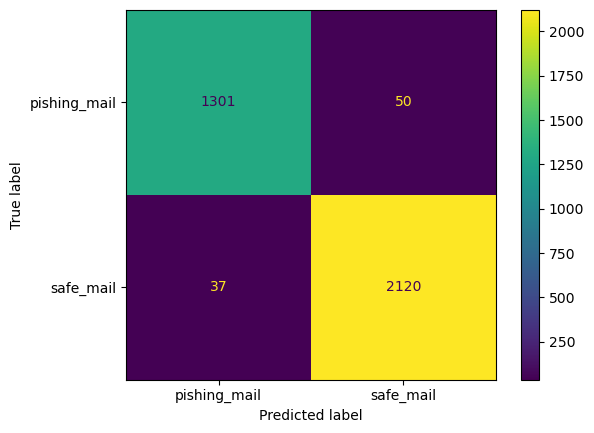

In [23]:
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
pred_nav = nb.predict(x_test)

# Checking the performance

print(f"accuracy from native bayes: {accuracy_score(y_test,pred_nav)*100:.2f} %")
print(f"f1 score from naive bayes: {f1_score(y_test,pred_nav)*100:.2f} %")
print("classification report :\n\n",classification_report(y_test,pred_nav))

#confusion matrix
clf_nav = confusion_matrix(y_test,pred_nav)
cx_ = ConfusionMatrixDisplay(clf_nav,display_labels=['pishing_mail','safe_mail']).plot()
plt.show()

## 5.2| Logistic Regression


accuracy from logistic regression:97.95 %
f1 score from logistic regression: 98.34 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1351
           1       0.98      0.99      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



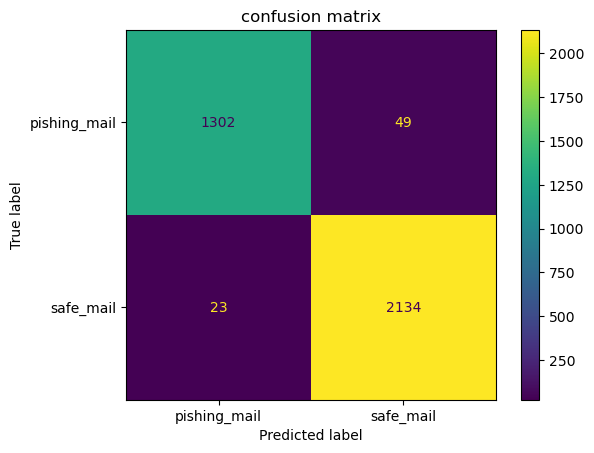

In [24]:
lg = LogisticRegression()
lg.fit(x_train,y_train)

# prediction
pred_lg = lg.predict(x_test)
# performance
print("")
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_lg)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_lg)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_lg))

clf_lg = confusion_matrix(y_test,pred_lg)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

In [25]:
# save the model for future use

import joblib

# Save the trained model to a file
joblib.dump(nb, 'email_spam_nb.pkl')

['email_spam_nb.pkl']

## 5.3| SGD Classifier

accuracy from logistic regression:98.46 %
f1 score from logistic regression: 98.75 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.99      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



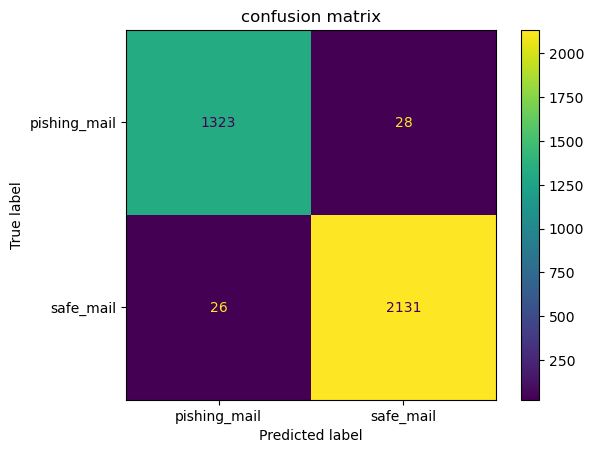

In [26]:
from sklearn.linear_model import SGDClassifier

# passing object
sgd = SGDClassifier()
sgd.fit(x_train,y_train)

# prediction
pred_sgd = sgd.predict(x_test)
# performance
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_sgd)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_sgd)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_sgd))

clf_sgd = confusion_matrix(y_test,pred_sgd)
cx_ = ConfusionMatrixDisplay(clf_sgd,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.4| XGBoost

accuracy from XGB:97.21 %
f1 score from XGB: 97.72 %
classification report : 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.97      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.97      0.97      0.97      3508



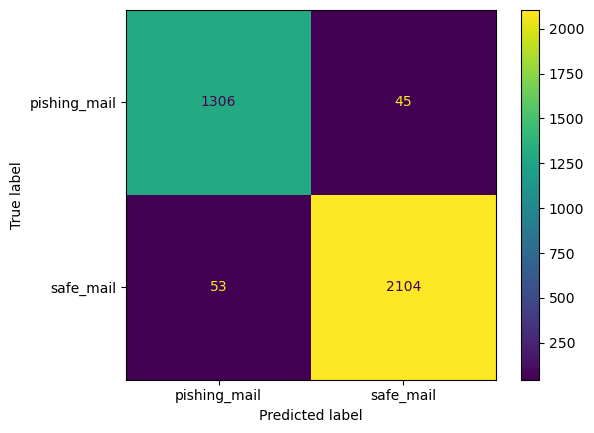

In [27]:
# applying boosting algorithm
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

#prediction
pred_xgb = xgb.predict(x_test)

#performance
print(f"accuracy from XGB:{accuracy_score(y_test,pred_xgb)*100:.2f} %")
print(f"f1 score from XGB: {f1_score(y_test,pred_xgb)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_xgb))

#confusion matrix
clf_xgb = confusion_matrix(y_test,pred_xgb)
cx_ = ConfusionMatrixDisplay(clf_xgb,display_labels=['pishing_mail','safe_mail']).plot()
plt.show()

## 5.5| Decision Tree

accuracy from Decision Tree:93.67 %
f1 score from Decision Tree: 94.81 %
classification report : 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      1351
           1       0.96      0.94      0.95      2157

    accuracy                           0.94      3508
   macro avg       0.93      0.94      0.93      3508
weighted avg       0.94      0.94      0.94      3508



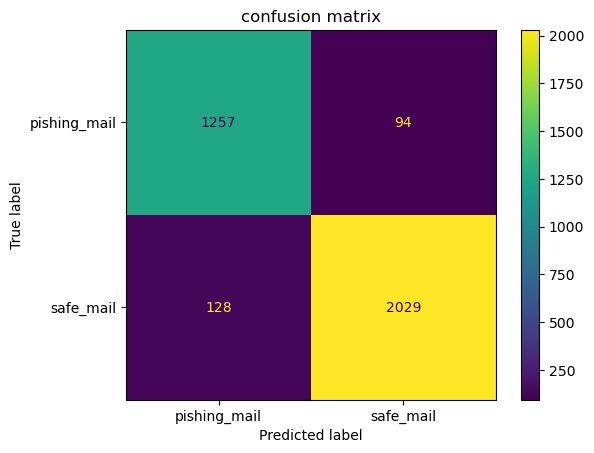

In [28]:
dtr = DecisionTreeClassifier() #passing object
dtr.fit(x_train,y_train)

#prediction
pred_dtr = dtr.predict(x_test)

#performance
print(f"accuracy from Decision Tree:{accuracy_score(y_test,pred_dtr)*100:.2f} %")
print(f"f1 score from Decision Tree: {f1_score(y_test,pred_dtr)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_dtr))

#confusion matrix
clf_dtr = confusion_matrix(y_test,pred_dtr)
cx_ = ConfusionMatrixDisplay(clf_dtr,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.6| Random Forest 

accuracy from rnadom forest:97.81 %
f1 score from random forest: 98.21 %
classification report : 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1351
           1       0.99      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



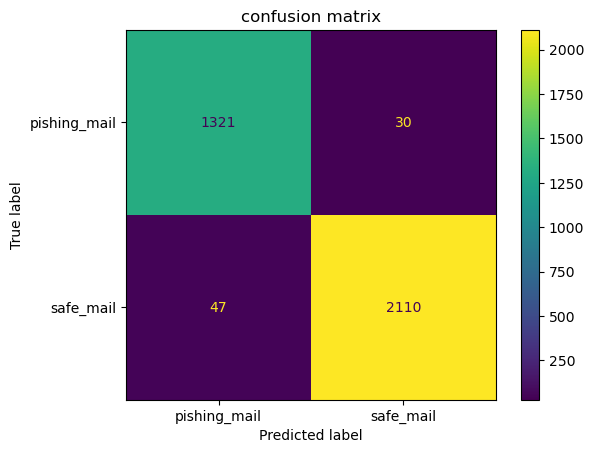

In [29]:
rnf = RandomForestClassifier() #passing object
rnf.fit(x_train,y_train)

#prediction
pred_rnf = rnf.predict(x_test)

#performance
print(f"accuracy from rnadom forest:{accuracy_score(y_test,pred_rnf)*100:.2f} %")
print(f"f1 score from random forest: {f1_score(y_test,pred_rnf)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_rnf))

#confusion matrix
clf_rnf = confusion_matrix(y_test,pred_rnf)
cx_ = ConfusionMatrixDisplay(clf_rnf,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.7| MLP Classifier (Multi-Layer perceptrons)

accuracy from MLP:98.43 %
f1 score from MLP: 98.73 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.99      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



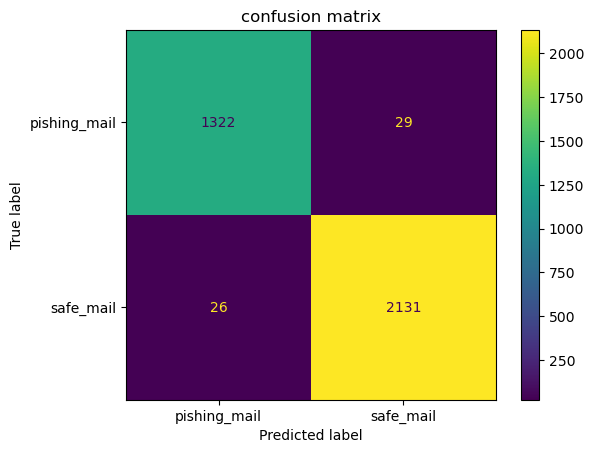

In [30]:
mlp = MLPClassifier()  # passing object
mlp.fit(x_train,y_train)

#prediction
pred_mlp = mlp.predict(x_test)

#performance
print(f"accuracy from MLP:{accuracy_score(y_test,pred_mlp)*100:.2f} %")
print(f"f1 score from MLP: {f1_score(y_test,pred_mlp)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_mlp))

#confusion matrix
clf_mlp = confusion_matrix(y_test,pred_mlp)
cx_ = ConfusionMatrixDisplay(clf_mlp,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.8| EDA comparison of the models performances

In [31]:
models = ['Naive bayes', 'Logistic Regression', 'SGD Classifier', 'XGBoost', 'Decision Tree', 'Random Forest', 'MLPClassifier']
accuracies = [97.52, 97.95, 98.57, 97.21, 93.67, 97.72, 98.29]

# Create the bar chart
fig = px.bar(x=models, y=accuracies, labels={'x': 'Models', 'y': 'Accuracy'},
             title="Performance of the models", text=accuracies)

# Customize the layout (optional)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside', marker_color='magenta')

# Show the plot
fig.show()

# 6| NN (Neural Network)

In [32]:
max_len = 150

tk = Tokenizer()

# Process the text

tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=max_len)

In [33]:
len(vector)

17538

In [34]:
x = np.array(vector)
y = np.array(df["Email Type"])

In [35]:
#Split the dataset into train and test set

x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

## 6.1| Simple RNN

In [36]:
model_smp = Sequential() # Sequential() API
model_smp.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_smp.add(SimpleRNN(units=100))
model_smp.add(Dropout(0.45))
model_smp .add(Dense(1, activation='sigmoid'))

In [37]:
model_smp.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [38]:
model_smp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
historical_smp  = model_smp.fit(x_train,y_train, epochs=7, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.5885 - loss: 0.6814 - val_accuracy: 0.6374 - val_loss: 0.6352
Epoch 2/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.6579 - loss: 0.5990 - val_accuracy: 0.7041 - val_loss: 0.5127
Epoch 3/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.7514 - loss: 0.4514 - val_accuracy: 0.6688 - val_loss: 0.5152
Epoch 4/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.7437 - loss: 0.4167 - val_accuracy: 0.7081 - val_loss: 0.5045
Epoch 5/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - accuracy: 0.7521 - loss: 0.4292 - val_accuracy: 0.7158 - val_loss: 0.4973
Epoch 6/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.7540 - loss: 0.4156 - val_accuracy: 0.6676 - val_loss: 0.5393
Epoch 7/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - accuracy: 0.7290 - loss: 0.4676 - val_accuracy: 0.7032 - val_loss: 0.5086


Text(0, 0.5, 'Loss')

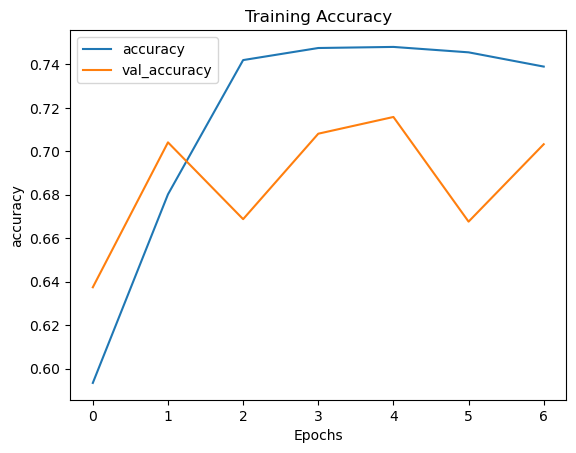

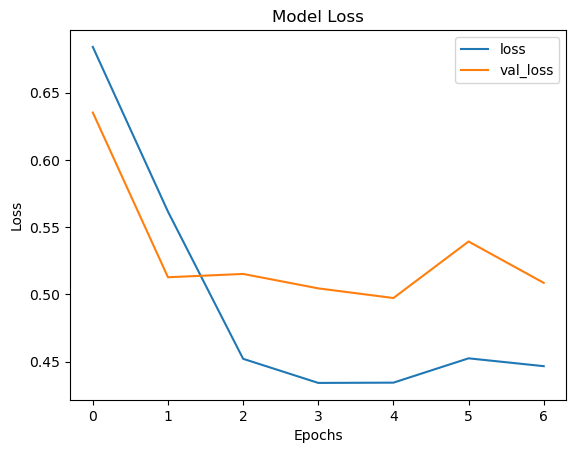

In [40]:
import matplotlib.pyplot as plt
pd.DataFrame(historical_smp.history)

pd.DataFrame(historical_smp.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_smp.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


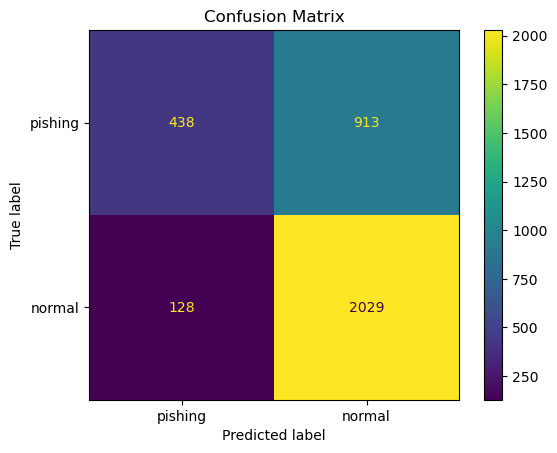

In [41]:
y_pred_prob_smp = model_smp.predict(x_test)
y_pred_smp = (y_pred_prob_smp > 0.5).astype(int)

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cnf_smp = confusion_matrix(y_test,y_pred_smp)
ax_smp = ConfusionMatrixDisplay(confusion_matrix=cnf_smp,display_labels=['pishing','normal']).plot()
plt.title("Confusion Matrix")
plt.show()

## 6.2| LSTM Architecture

In [42]:
model = Sequential() # Sequential() API
model.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model.add(LSTM(units=100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
historical  = model.fit(x_train,y_train, epochs=5, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/5


877/877 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.6575 - loss: 0.5975 - val_accuracy: 0.7526 - val_loss: 0.4081
Epoch 2/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 58s 66ms/step - accuracy: 0.8376 - loss: 0.3405 - val_accuracy: 0.9051 - val_loss: 0.2624
Epoch 3/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 59s 67ms/step - accuracy: 0.9458 - loss: 0.1811 - val_accuracy: 0.9572 - val_loss: 0.1782
Epoch 4/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9679 - loss: 0.1193 - val_accuracy: 0.9609 - val_loss: 0.1279
Epoch 5/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 58s 66ms/step - accuracy: 0.9840 - loss: 0.0506 - val_accuracy: 0.9607 - val_loss: 0.1314


# 7| Performance

In [46]:
results = model.evaluate(x_test, y_test)
loss = results[0]  # Extract the loss from the results
accuracy = results[1]  # Extract the accuracy from the results

print(f"Model Loss: {loss}")
print(f"Model Accuracy: {accuracy*100}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9645 - loss: 0.1228
Model Loss: 0.13138985633850098
Model Accuracy: 96.06613516807556


In [47]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Text(0, 0.5, 'Loss')

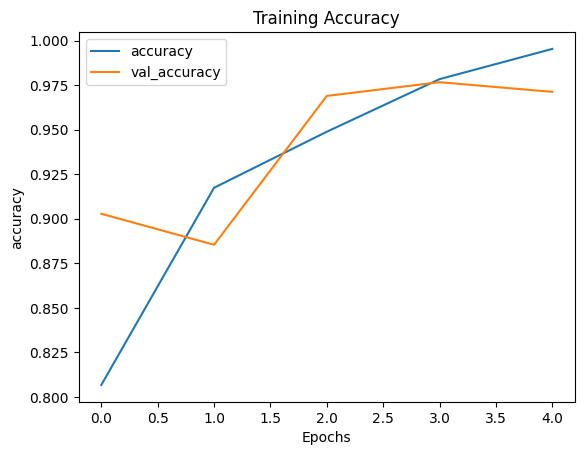

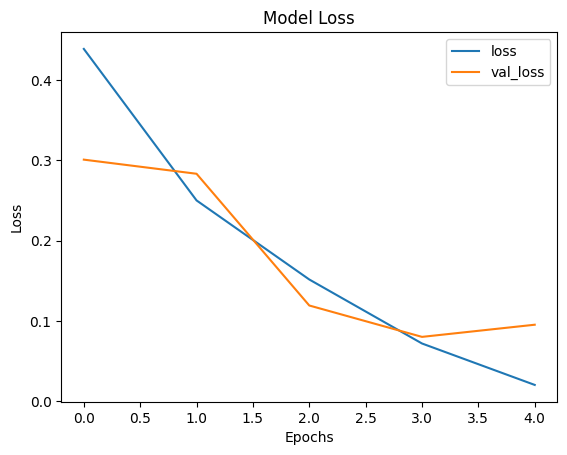

In [ ]:
pd.DataFrame(historical.history)

pd.DataFrame(historical.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

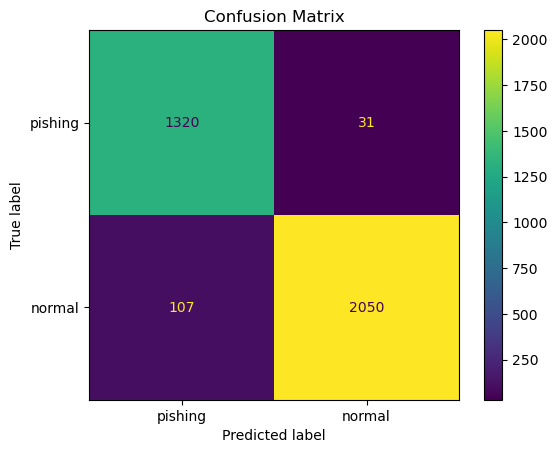

In [48]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['pishing','normal'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

# 8| Bidirectional

In [49]:
model_bi = Sequential() # Sequential() API
model_bi.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_bi.add(Bidirectional(LSTM(units=100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(1, activation='sigmoid'))

In [50]:
model_bi.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [51]:
model_bi.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
historical  = model_bi.fit(x_train,y_train, epochs=2, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/2
877/877 ━━━━━━━━━━━━━━━━━━━━ 65s 72ms/step - accuracy: 0.8283 - loss: 0.3854 - val_accuracy: 0.8940 - val_loss: 0.3127
Epoch 2/2
877/877 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9452 - loss: 0.1714 - val_accuracy: 0.9769 - val_loss: 0.0776


In [53]:
model_bi.evaluate(x_test,y_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9813 - loss: 0.0706


[0.07756433635950089, 0.9769099354743958]

In [54]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


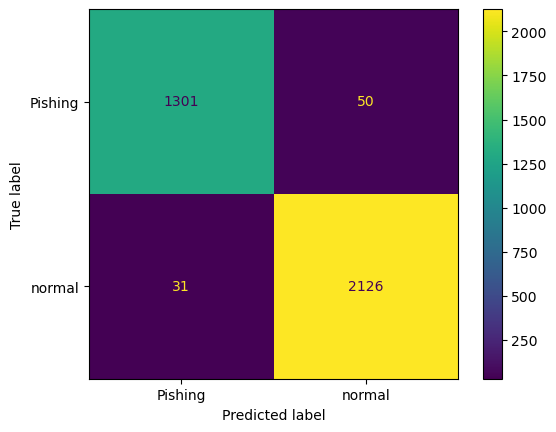

In [55]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Pishing','normal'])
ax_bi.plot()
plt.show()

# 9| GRU (Gated Recurrent Unit)

In [56]:
model_gru = Sequential() # Sequential() API
model_gru.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_gru.add(GRU(units=100))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

In [57]:
model_gru.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
model_gru.fit(x_train,y_train, epochs=3, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/3
877/877 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.6648 - loss: 0.5884 - val_accuracy: 0.9709 - val_loss: 0.0916
Epoch 2/3
877/877 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9799 - loss: 0.0639 - val_accuracy: 0.9795 - val_loss: 0.0623
Epoch 3/3
877/877 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9979 - loss: 0.0101 - val_accuracy: 0.9795 - val_loss: 0.0670


In [59]:
y_pred_prob_gru = model_gru.predict(x_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


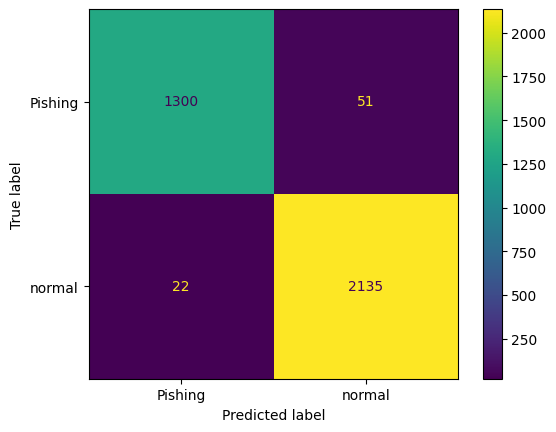

In [ ]:
cnf_gru = confusion_matrix(y_test,y_pred_gru)
ax_gru = ConfusionMatrixDisplay(confusion_matrix=cnf_gru,display_labels=['Pishing','normal'])
ax_gru.plot()
plt.show()

### Thanks for watching upvotes ###